<a href="https://colab.research.google.com/github/NITIN9694/TensorFlow-Learning/blob/main/10_SKIMLIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts eaiser.

we went through some fundamental natural lanuage processing concepts. The main ones being tokenzation (turning words into numbers) and creating embeddings (creating a numerical representation of words).

In this project, we're going to be putting what we've learned into practice.

More specificially,[ we're going to be replicating the deep learning model behind the 2017 paper PubMed 200k RCT:](https://arxiv.org/pdf/1710.06071) a Dataset for Sequenctial Sentence Classification in Medical Abstracts.

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

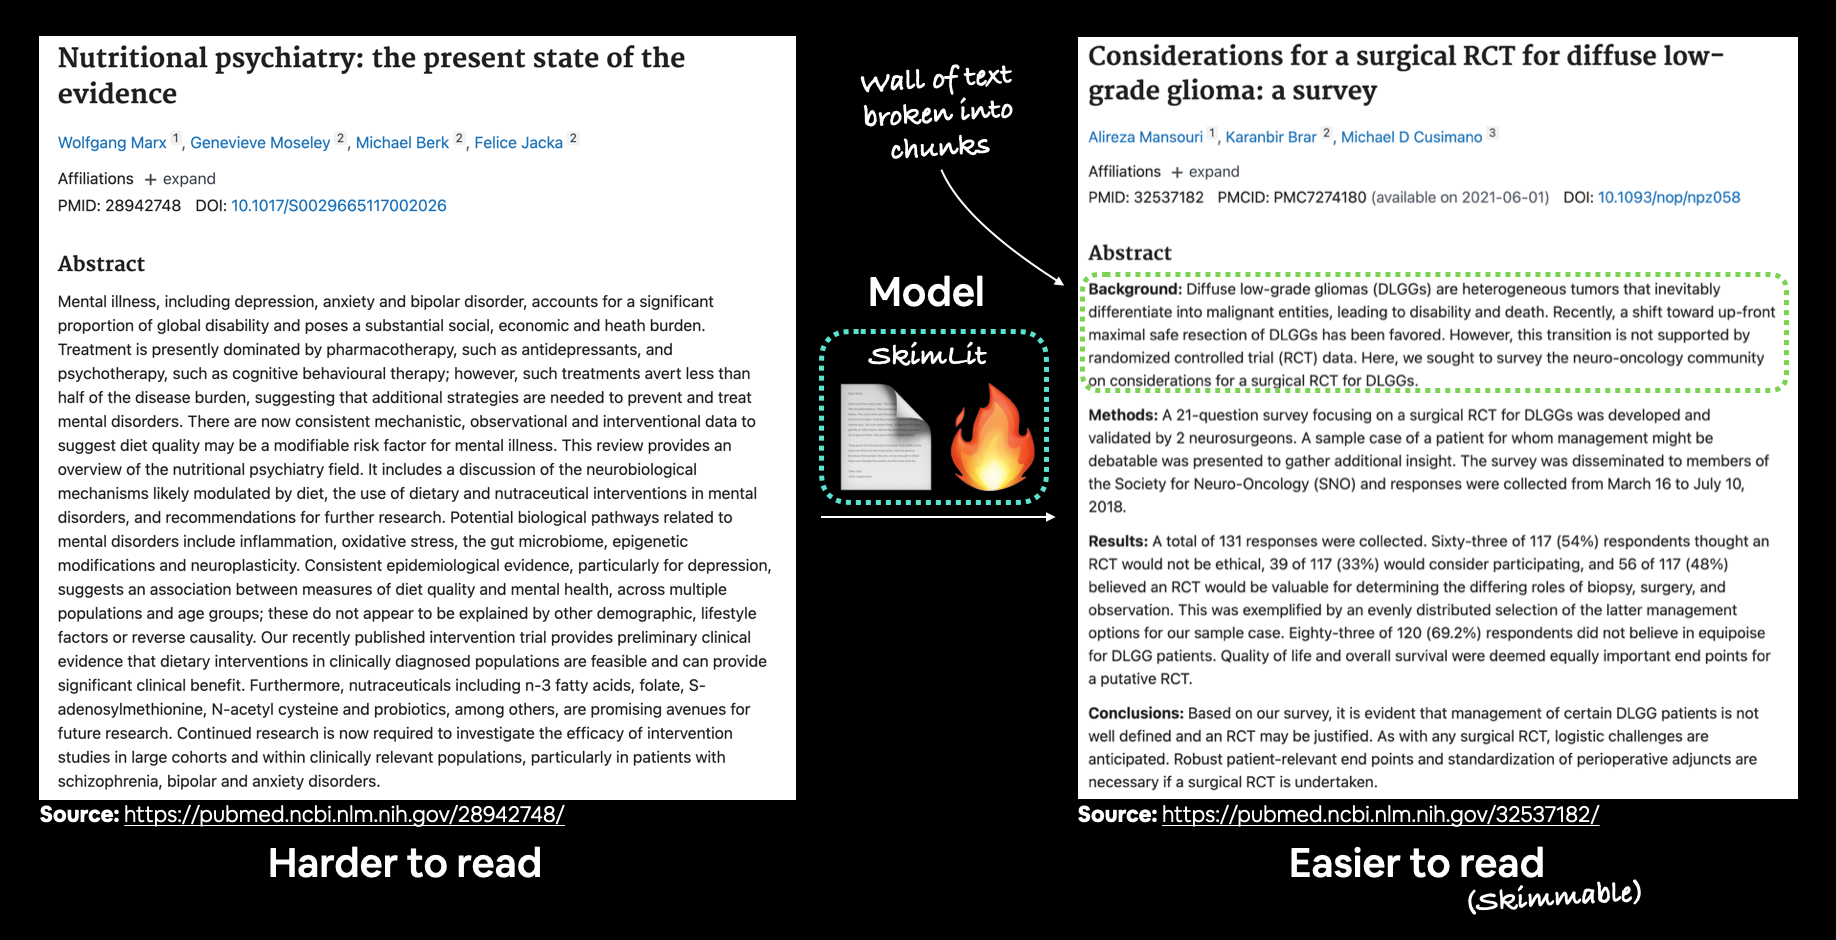

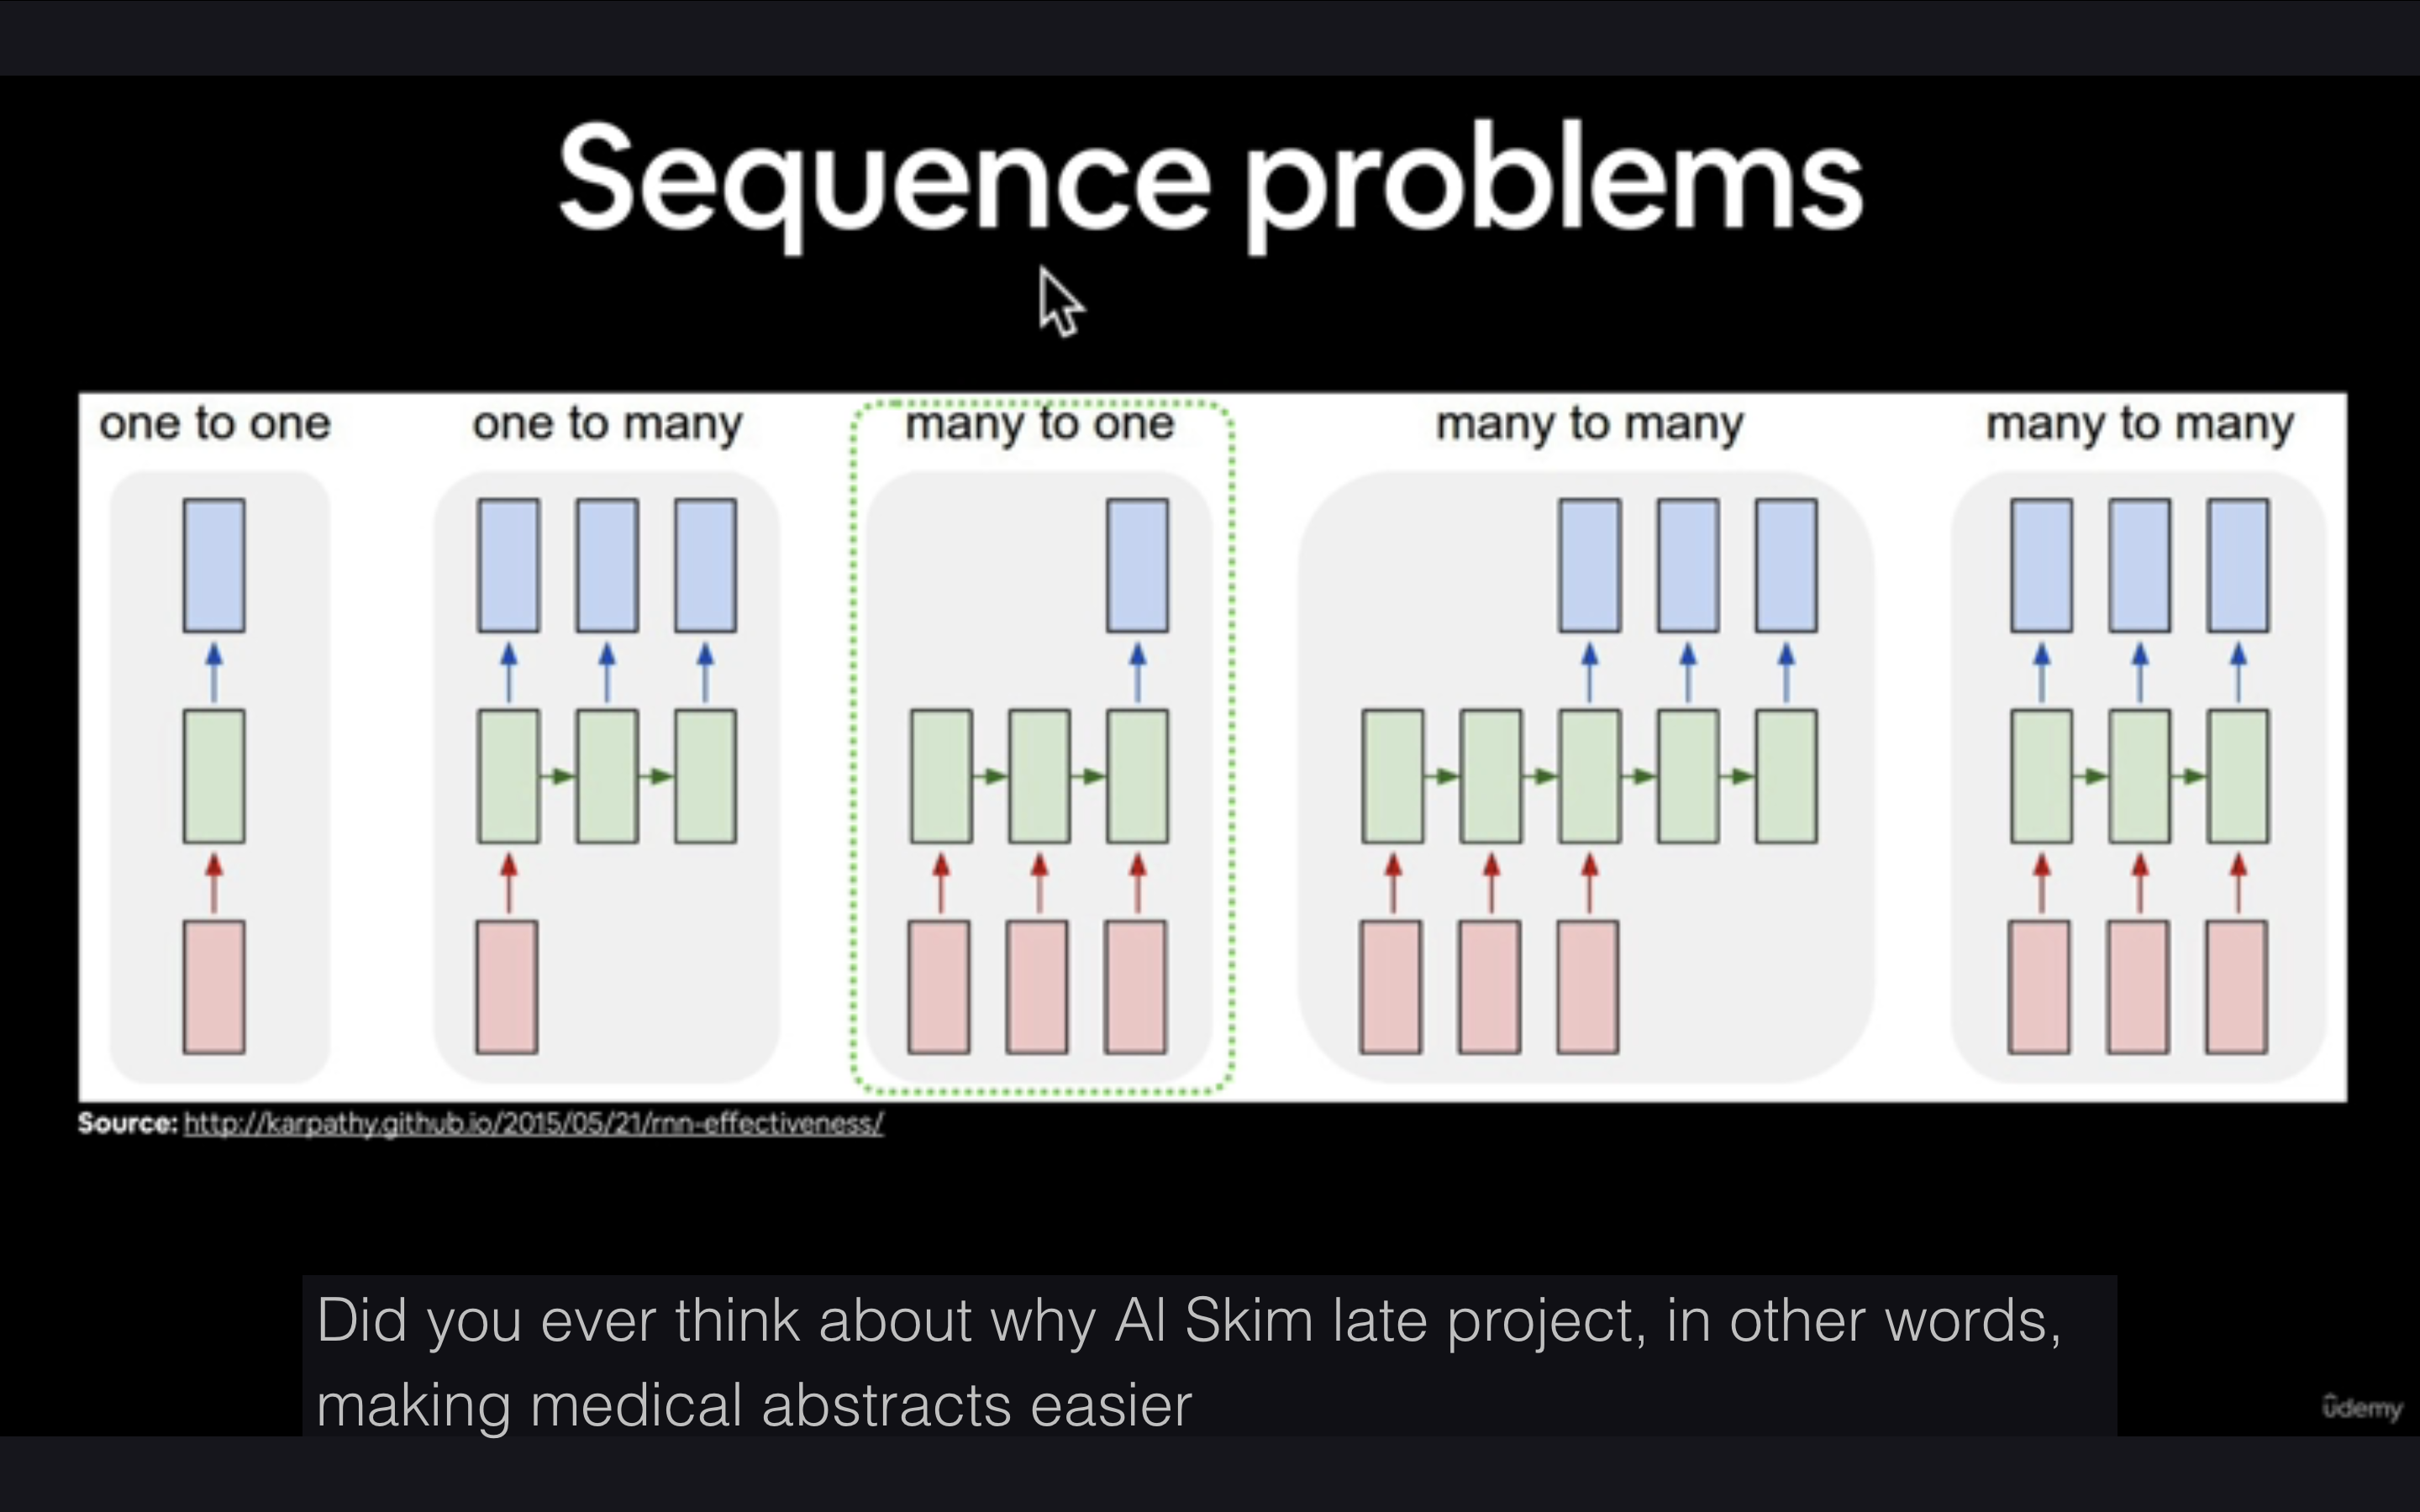

##Problem in a sentence
The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literatur

##Solution in a sentence
Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

1. Where our data is coming from: [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)
2. Where our model is coming from: [Neural networks for joint sentence classification in medical paper abstracts.](https://arxiv.org/pdf/1612.05251.pdf)

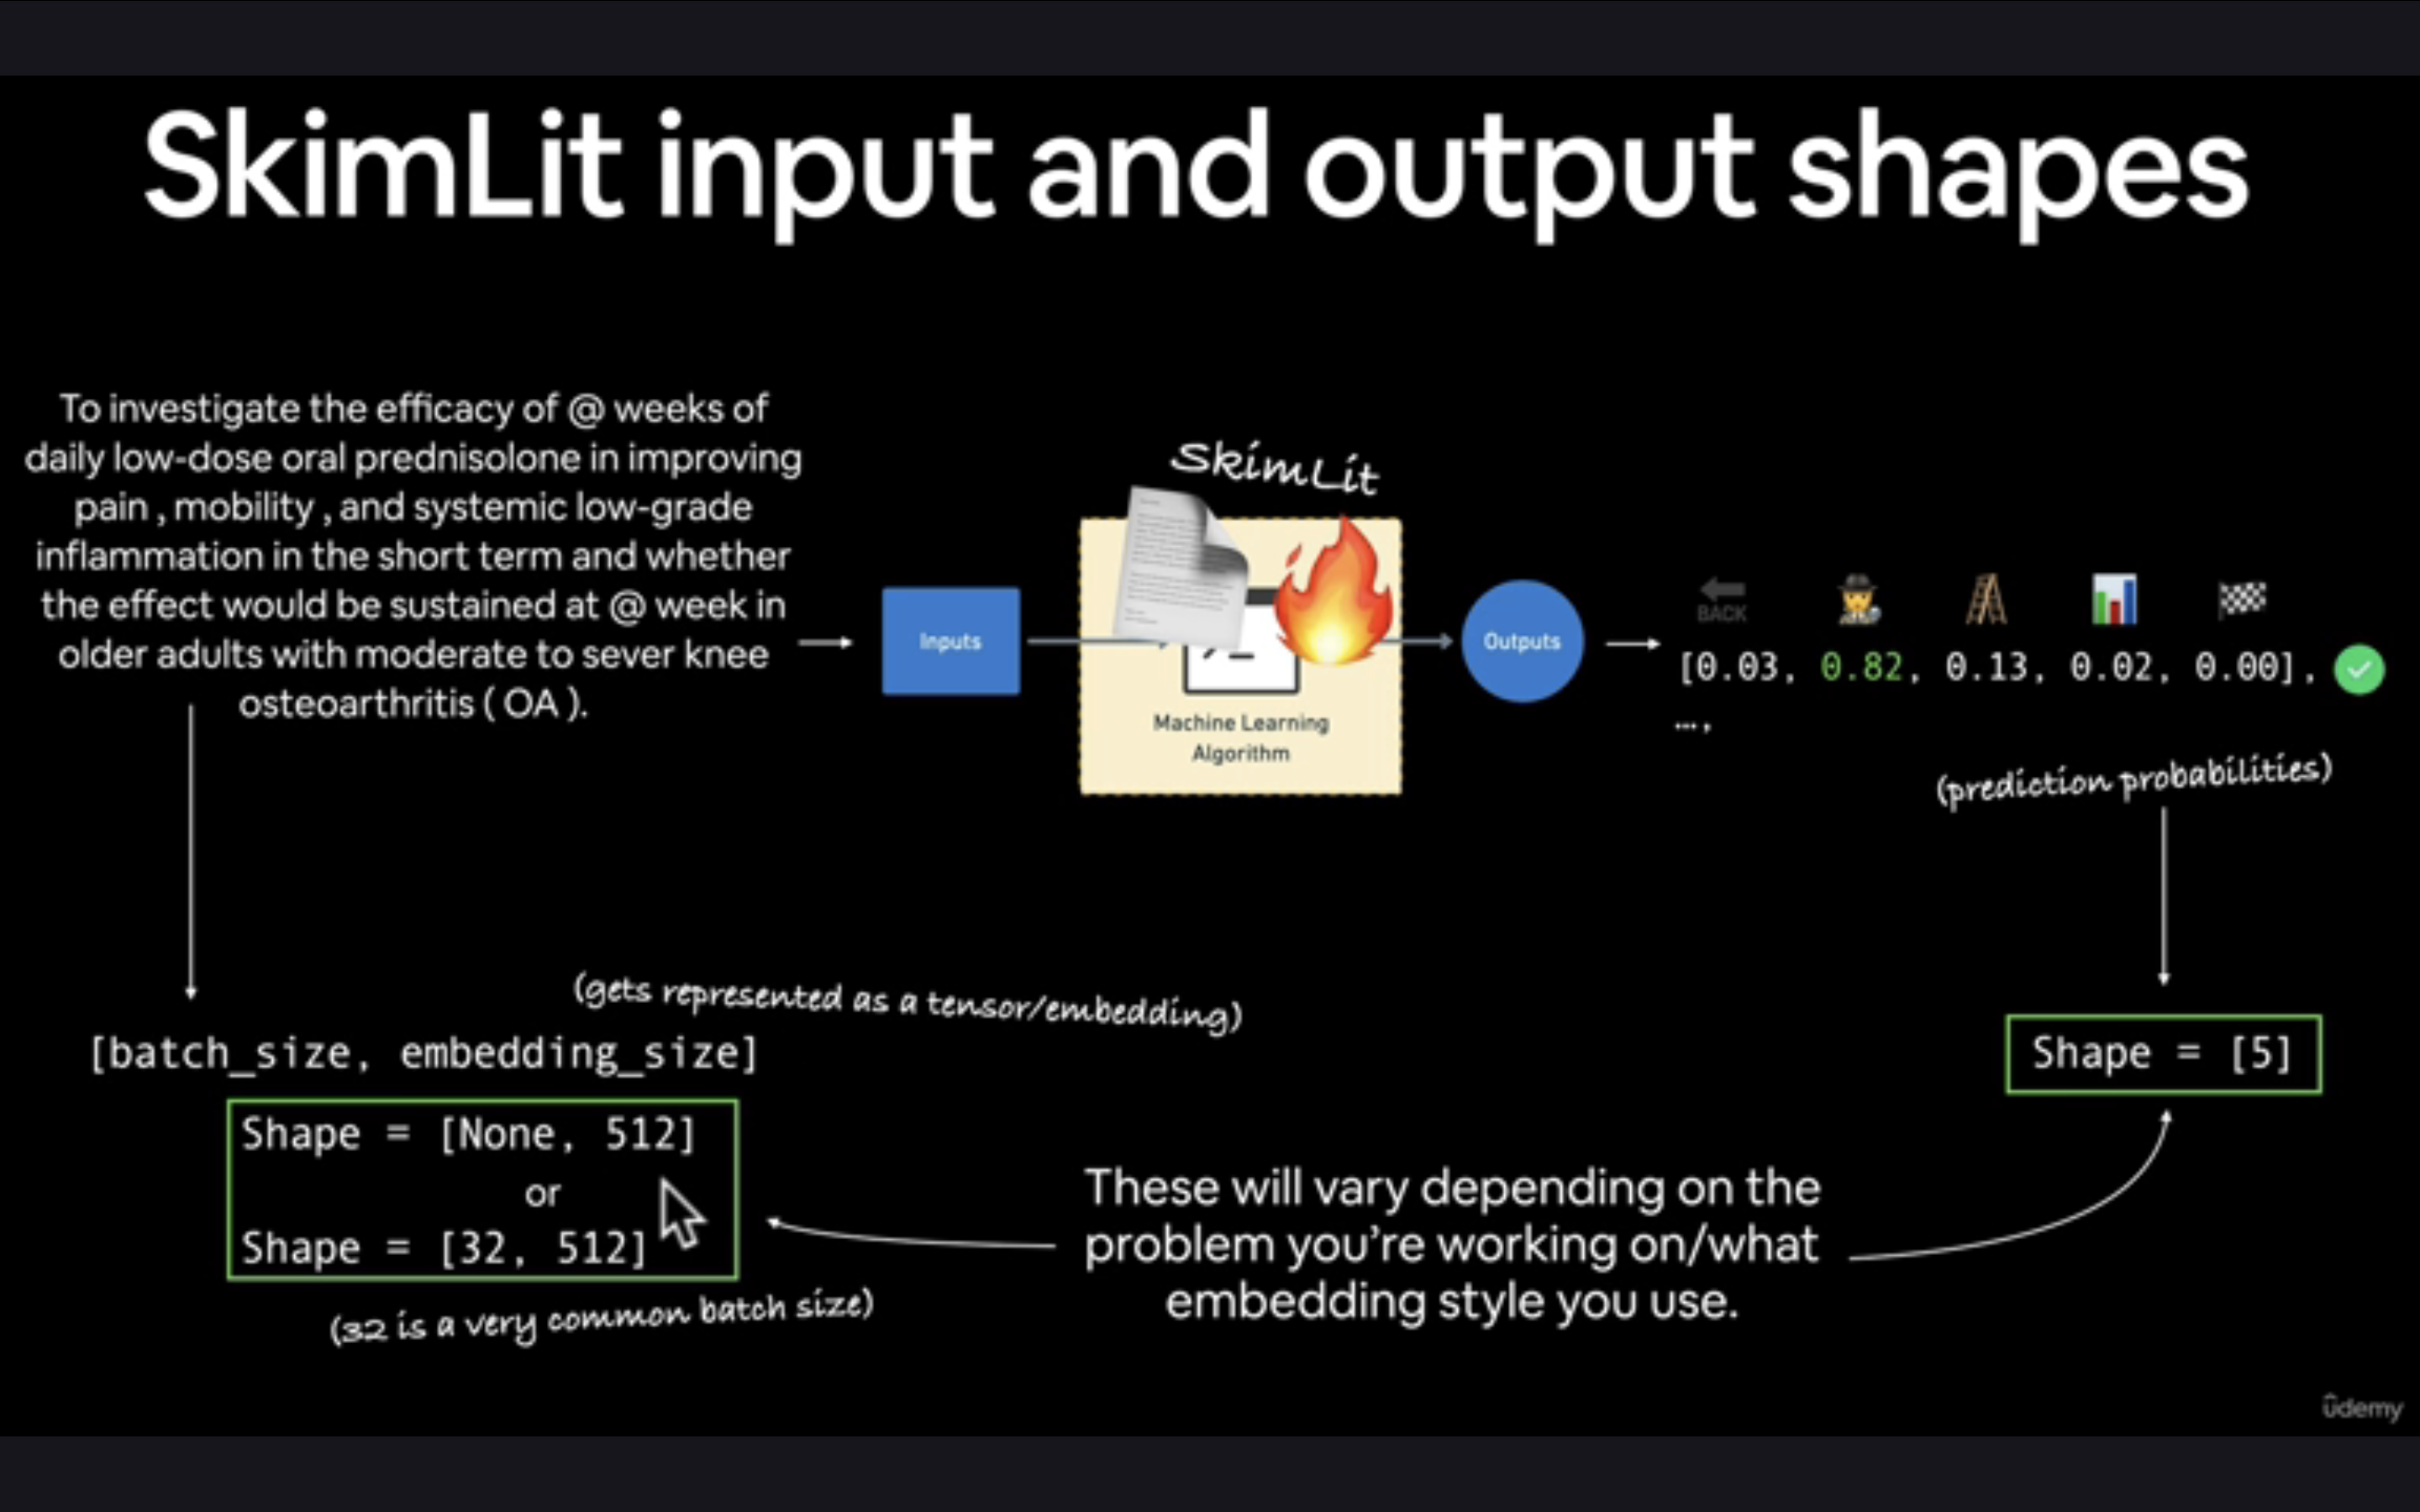

In [1]:
!nvidia-smi

Mon Jan 12 12:03:03 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Get Data

Since we replicating the paper above(Pubmed 200k RCT), lets download the dataset they used

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 12.87 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [3]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.zip


In [5]:
#start our experiment using the 20k dataset with number replaced by "@" sing
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
#check all the filename in the target dicertory
import os
filename = [data_dir + filename for filename in os.listdir(data_dir)]
filename

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

###Preprocess data



In [7]:

# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [8]:
data_dir
train_line = get_lines(data_dir+"train.txt")
train_line[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Writing the funcation to turn each of data in format

In [9]:

def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 317 ms, sys: 69 ms, total: 386 ms
Wall time: 386 ms


(180040, 30212, 30135)

In [11]:

# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df  = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df

target                                               text  \
0         OBJECTIVE  to investigate the efficacy of @ weeks of dail...   
1           METHODS  a total of @ patients with primary knee oa wer...   
2           METHODS  outcome measures included pain reduction and i...   
3           METHODS  pain was assessed using the visual analog pain...   
4           METHODS  secondary outcome measures included the wester...   
...             ...                                                ...   
180035      RESULTS  for the absolute change in percent atheroma vo...   
180036      RESULTS  for pav , a significantly greater percentage o...   
180037      RESULTS  both strategies had acceptable side effect pro...   
180038  CONCLUSIONS  compared with standard statin monotherapy , th...   
180039  CONCLUSIONS  ( plaque regression with cholesterol absorptio...   

        line_number  total_lines  
0                 0           11  
1                 1           11  
2                 2           11  
3                 3           11  
4                 4           11  
...             ...          ...  
180035            7           11  
180036            8           11  
180037            9           11  
180038           10           11  
180039           11           11  

[180040 rows x 4 columns]

In [13]:
print(f"Length of test_sentence: {len(test_samples)}")


Length of test_sentence: 30135


As you can see from the output above, `test_sentence` and `test_label_encoder` have different lengths (30212 vs 30135). They **must** have the same length to create a TensorFlow dataset.

Assuming you have a `test_df` DataFrame, you should extract the sentences and labels from it to ensure they are aligned. Remember to replace `'sentence_column_name'` and `'label_column_name'` with the actual column names in your `test_df`.

In [14]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

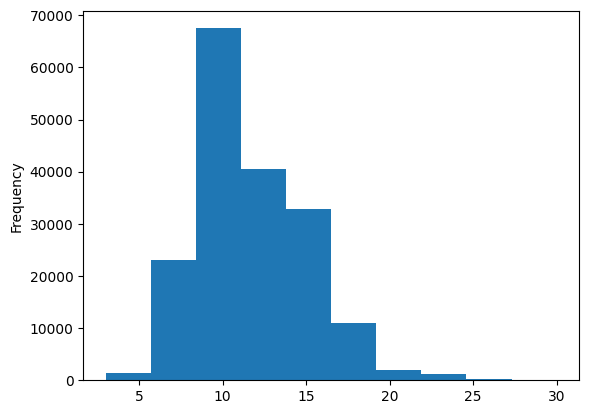

In [15]:
#Let check the lenght of diffrent line
train_df.total_lines.plot.hist()

##Get lists of sentences

In [16]:
#convert abstrac text lines into line
train_sentence = train_df["text"].tolist()
val_sentence = val_df["text"].tolist()
test_sentence = val_df["text"].tolist()
len(train_sentence), len(val_sentence), len(test_sentence)

(180040, 30212, 30212)

In [17]:
test_sentence[:20]

['ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
 'it is not clear whether these patients would benefit from antifungal treatment .',
 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
 'primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .',
 'sixty-five patients were randomized .',
 'fifty-nine patients started treatment ( @ receiving voriconazole and @ receiving plac

#Make numeric labels (ML models require numeric labels)

In [18]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_label_encoder = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
test_label_encoder = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

val_label_encoder = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))

train_label_encoder

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

###Label encode labels

In [19]:

# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
class_name = label_encoder.classes_

class_name

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

##Starting a series of modeling experiments
As usual we're going to be trying out of bunch of diffrent model and seeing which one works best.
We are goinng start with baseline (TF-IDF Multinative Base Line)

##Model 0: Base line

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import  MultinomialNB
from sklearn.pipeline import Pipeline


#Create a pipline
model_0 = Pipeline(
    [
        ("tf-idf",TfidfVectorizer()),
        ("clf",MultinomialNB())
    ]
)

#Fit the piplint to the training data

model_0.fit(X=train_sentence,
            y=train_labels_encoded
            )


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
#Evalauate baseline model on validation dataset
model_0.score(
    X=val_sentence,
    y=val_labels_encoded
)

0.7218323844829869

In [23]:
#Make prediction using our baseline
baseline_pred = model_0.predict(
    val_sentence
)
baseline_pred

array([4, 1, 3, ..., 4, 4, 1])

###Download helper funcation script


In [24]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2026-01-12 12:03:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2026-01-12 12:03:26 (140 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
from helper_functions import calculate_results

In [26]:
#calculate results
base_line_results = calculate_results(y_true=val_labels_encoded,
                                      y_pred=baseline_pred
                                      )

In [27]:
base_line_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

###Preparing our data for deep sequence models

Create vectorization and embedding layers.

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

In [28]:

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [29]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentence]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

np.float64(26.338269273494777)

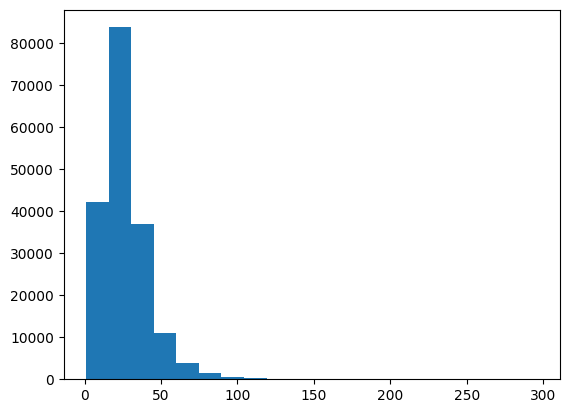

In [30]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);


In [31]:

# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [32]:
# Maximum sentence length in the training set
max(sent_lens)


296

###Create text vectoriser

```
We want to make layer which maps our text from word to number
```



In [33]:

# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000


In [34]:
from tensorflow.keras.layers import TextVectorization

# Before TensorFlow 2.6
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences


In [35]:

# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentence)

In [36]:
import random
target_sentence = random.choice(train_sentence)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the challenge of controlling pain during pdt on pws remains .

Length of text: 11

Vectorized text:
[[    2  1647     4  1708    65    52  2342    18 12422   876     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [37]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of')]
Least common words in the vocabulary: [np.str_('aainduced'), np.str_('aaigroup'), np.str_('aachener'), np.str_('aachen'), np.str_('aaacp')]


In [38]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

###Create Custom Text Embedding


In [39]:
token_embed = layers.Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim = 128,
    mask_zero = True,
    name = "token_embeding"
)

In [40]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")


Sentence before vectorization:
the challenge of controlling pain during pdt on pws remains .

Sentence after vectorization (before embedding):
[[    2  1647     4  1708    65    52  2342    18 12422   876     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.02622655 -0.03738683 -0.03743589 ...  0.0275605   0.0497612
   -0.01965808]
  [-0.04823187 -0.03411146  0.00780507 ...  0.04714075  0.03254279
   -0.02799997]
  [-0.02276953 -0.02033063 -0.0339789  ...  0.04557539  0.04461135
   -0.01689184]
  ...
  [ 0.03847535  0.02139452  0.00913215 ... -0.01000194 -0.03633427
    0.00710849]
  [ 0.03847535  0.02139452  0.00913215 ... -0.01000194 -0.03633427
    0.00710849]
  [ 0.03847535  0.02139452  0.00913215 ... -0.01000194 -0.03633427
 

##Create datasets (as fast as possible)

We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the tf.data API provides methods which enable faster data loading.

📖 Resource: For best practices on data loading in TensorFlow, check out the following:

* tf.data: [Build TensorFlow input pipelines Better performance with the ](https://www.tensorflow.org/guide/data)
* [tf.data API The main steps we'll want to use with our data is to turn it into a PrefetchDataset of batches.](https://www.tensorflow.org/guide/data_performance)

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched PrefetchDataset we can use the methods batch() and prefetch(), the parameter tf.data.AUTOTUNE will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [41]:
#Turn our data into TensorFlow DataSet
train_data = tf.data.Dataset.from_tensor_slices((train_sentence,train_label_encoder))
val_data = tf.data.Dataset.from_tensor_slices((val_sentence,val_label_encoder))
# test_data = tf.data.Dataset.from_tensor_slices((test_sentence,test_label_encoder))


train_data

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [42]:
# Take the TensorSliceDataset's and turn them into prefetched batches

train_dataset = train_data.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = val_data.batch(32).prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

##Model 1 (Conv1D with token embeding)

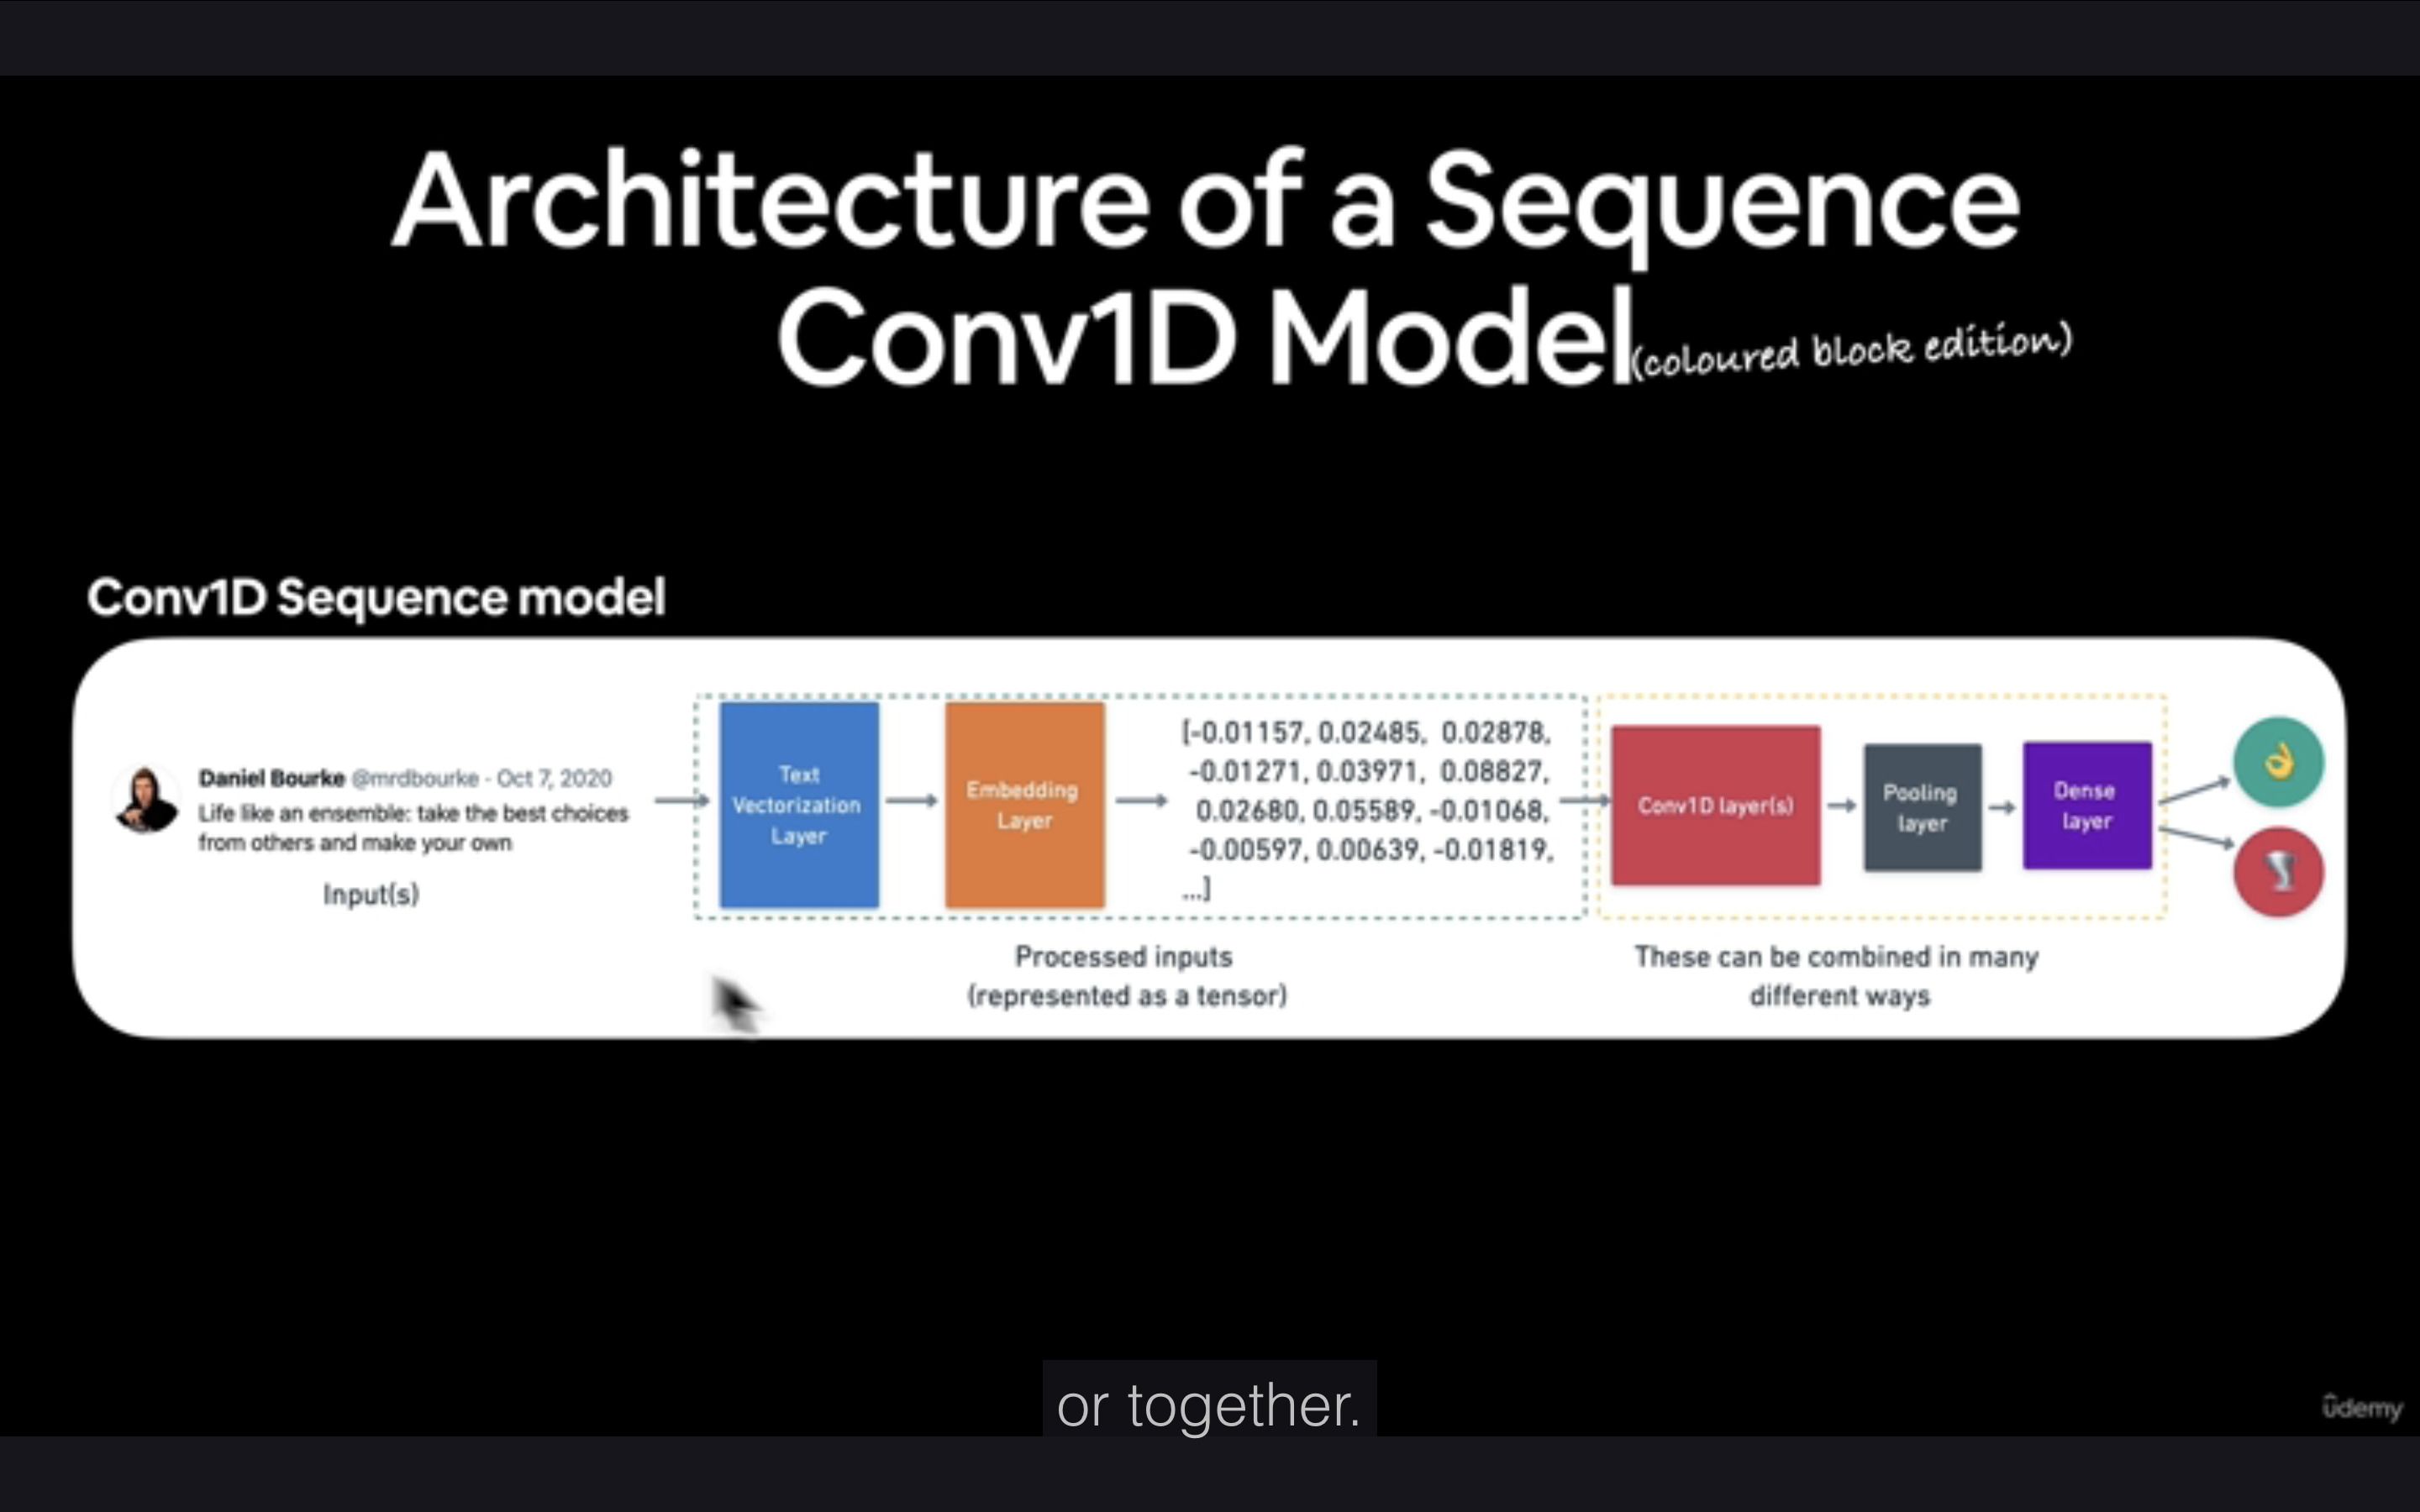

All of our deep models will follow a similar structure:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability

In [43]:
#Create 1D conv model to process sequence

input = layers.Input(shape = (1,),dtype = tf.string)

text_vectors = text_vectorizer(input) #vectorizer text input
token_embeding = token_embed(text_vectors) #create embeding
x = layers.Conv1D(64,kernel_size =5 ,padding = "same",activation = "relu")(token_embeding)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(5,activation = "softmax")(x)
model_1 = tf.keras.Model(input,output)





/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [44]:
#compile the model
model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]

)


In [45]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embeding (Embedding)      │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
 #fit the model

history_model_1 = model_1.fit(train_dataset,
                               steps_per_epoch= int(0.1 * len(train_dataset)),
                               epochs = 3,
                               validation_data = valid_dataset,
                               validation_steps = int(0.1 * len(valid_dataset))#only validate on 10% of benche
                               )

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5299 - loss: 1.1592 - val_accuracy: 0.7410 - val_loss: 0.6873
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7477 - loss: 0.6800 - val_accuracy: 0.7733 - val_loss: 0.6286
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7701 - loss: 0.6222 - val_accuracy: 0.7832 - val_loss: 0.5995


In [47]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7859 - loss: 0.5975


[0.5995794534683228, 0.7866079807281494]

In [48]:
#make predictions
model_1_pred_prob = model_1.predict(valid_dataset)
model_1_pred_prob

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[4.3848100e-01, 1.3174841e-01, 8.0778003e-02, 3.1634063e-01,
        3.2651991e-02],
       [4.5129174e-01, 2.8438148e-01, 1.0228308e-02, 2.4720642e-01,
        6.8920362e-03],
       [1.7121828e-01, 5.2324417e-03, 1.8146184e-03, 8.2171041e-01,
        2.4287208e-05],
       ...,
       [7.3374817e-06, 5.6600175e-04, 7.9786283e-04, 5.2678761e-06,
        9.9862349e-01],
       [4.6765473e-02, 4.4171456e-01, 8.5894577e-02, 4.9376838e-02,
        3.7624857e-01],
       [1.7122640e-01, 6.6729361e-01, 5.6870490e-02, 4.8827875e-02,
        5.5781629e-02]], dtype=float32)

In [49]:
model_1_pred_prob.shape

(30212, 5)

In [50]:
model_1_pred = tf.argmax(model_1_pred_prob,axis = 1)
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [51]:
#calculate model 1

model_1_result = calculate_results (y_true = val_labels_encoded,
                                    y_pred = model_1_pred
                                   )

model_1_result

{'accuracy': 78.66079703429101,
 'precision': 0.7839613429011827,
 'recall': 0.7866079703429101,
 'f1': 0.7846890180930103}

In [52]:
base_line_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

##Model 2: Feature extraction with pretrained token embeddings

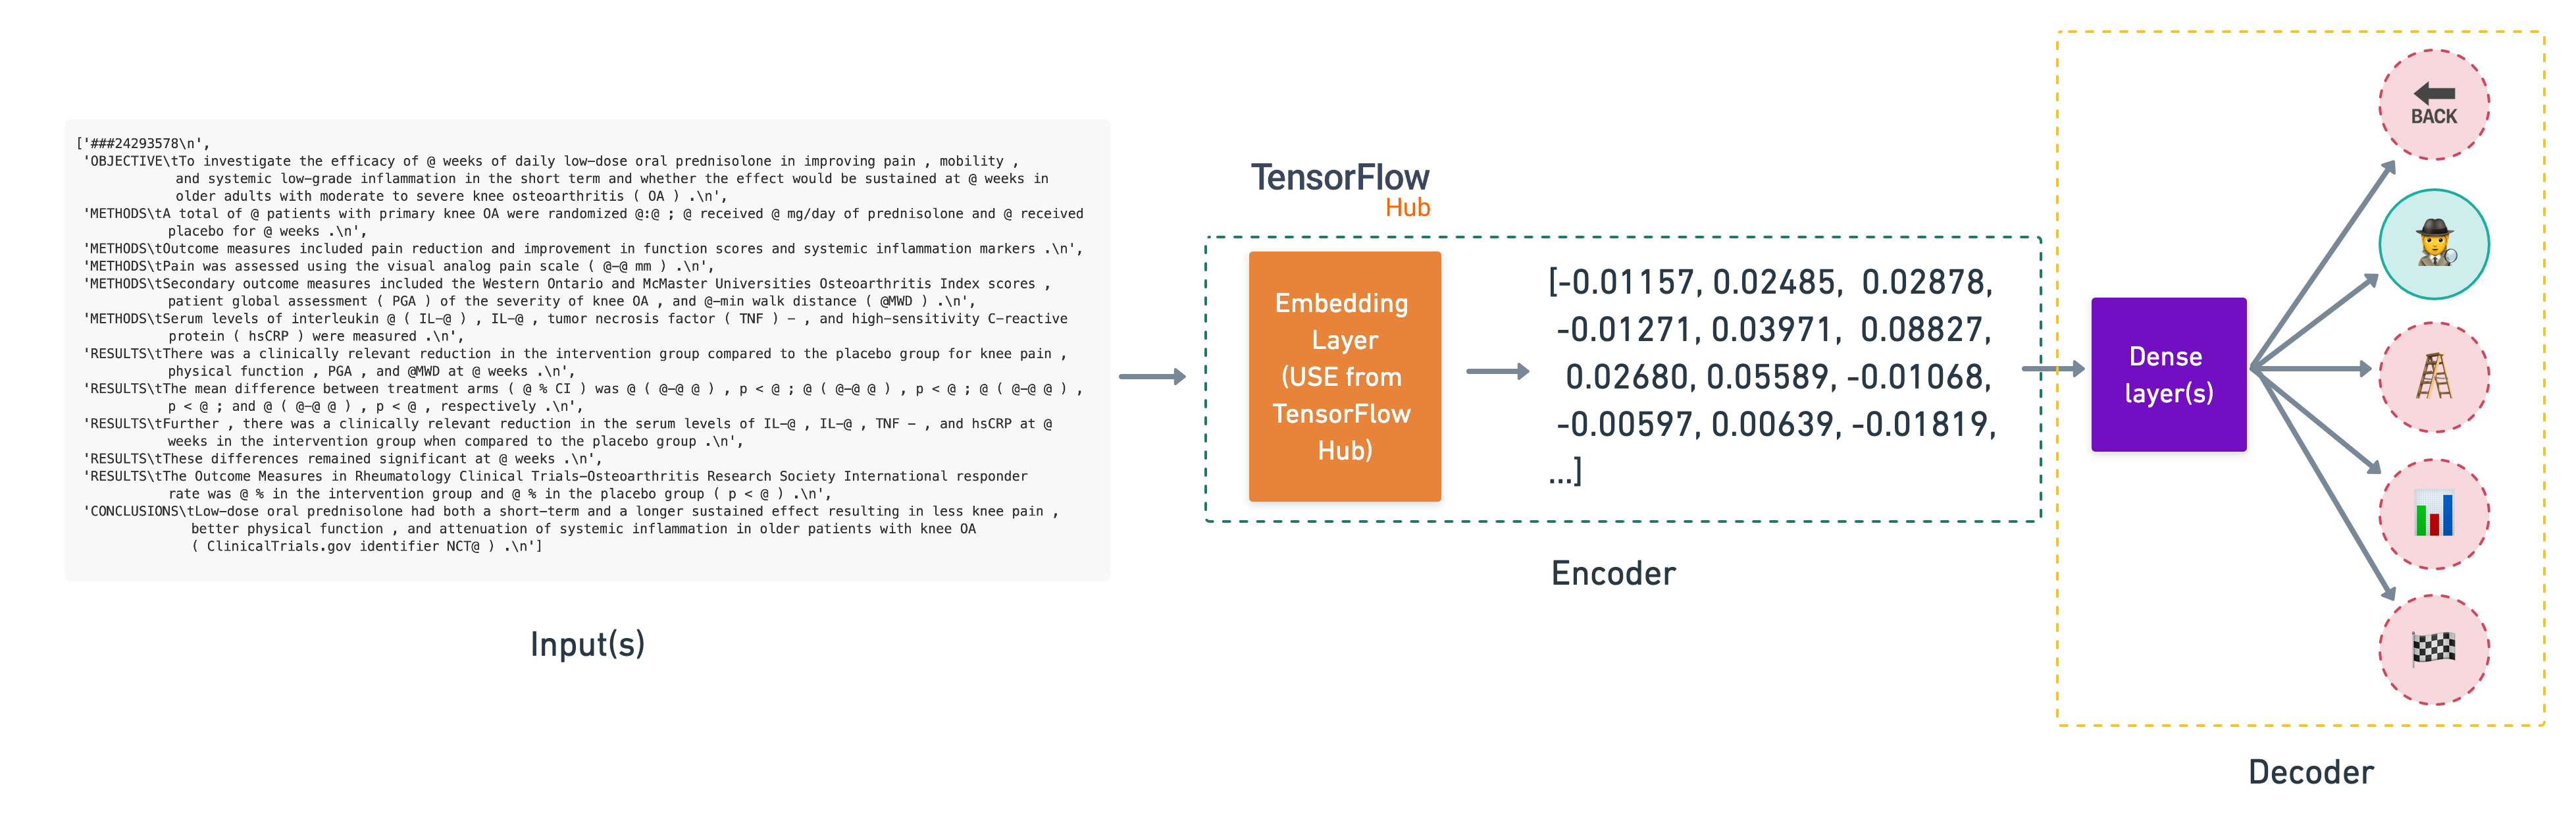

The model structure will look like:

Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)


In [53]:

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [54]:

# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentence)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")


Random training sentence:
assessments were made at baseline ( t@ ) , @ month ( t@ ) , and @ months ( t@ ) after ac ; pain , maximum mouth opening , and joint sounds before and after treatment up to @ months were evaluated .

Sentence after embedding:
[-0.00894036 -0.00684472 -0.06191597  0.02612861 -0.08402629  0.00727848
  0.03958505  0.00504871 -0.02577555  0.03370987  0.07580747 -0.04547701
 -0.03158535 -0.00224743  0.00353375  0.0612536  -0.05827159  0.07076474
  0.02269137  0.03701953 -0.03148813  0.07145452 -0.05336423  0.00712216
 -0.07843293  0.03602966 -0.05037637 -0.02545322 -0.0725111  -0.05865542] (truncated output)...

Length of sentence embedding:
512


##Building and fiting an NLP feature extraction model using pretrained embeddings

In [66]:
#Define feature extraction model using TG hub layer
input  = layers.Input(shape=[], dtype = tf.string)
# Wrap tf_hub_embedding_layer in a Lambda layer to ensure proper functional API integration
pretrained_embedding = layers.Lambda(lambda x: tf_hub_embedding_layer(x), output_shape=(512,))(input)
x = layers.Dense(128, activation = "relu")(pretrained_embedding)
output = layers.Dense(5,activation="softmax")(x)
model_2 = tf.keras.Model(input,output,name="model_2_USE")


#compile model

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"],
                jit_compile=False) # Disable JIT compilation to avoid XLA error with string inputs


history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                               steps_per_epoch= int(0.1 * len(train_dataset)),

                               validation_data = valid_dataset,
                               validation_steps = int(0.1 * len(valid_dataset)),
)

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5784 - loss: 1.0862 - val_accuracy: 0.6892 - val_loss: 0.7972
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7021 - loss: 0.7717 - val_accuracy: 0.7055 - val_loss: 0.7562
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7114 - loss: 0.7559 - val_accuracy: 0.7108 - val_loss: 0.7410


In [68]:
#evalute on the validatiin dataset
model_2.evaluate(valid_dataset
                 )

945/945 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7121 - loss: 0.7416


[0.7437413334846497, 0.7115384340286255]

In [70]:
model_2_pred_prob = model_2.predict(valid_dataset)
model_2_pred_prob

945/945 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step


array([[4.1067570e-01, 3.8594469e-01, 2.4681746e-03, 1.9164616e-01,
        9.2652459e-03],
       [3.7186706e-01, 4.8616359e-01, 3.6223761e-03, 1.3473344e-01,
        3.6134501e-03],
       [2.6229426e-01, 1.5361628e-01, 1.7065903e-02, 5.2962303e-01,
        3.7400506e-02],
       ...,
       [1.9746695e-03, 6.2509188e-03, 5.4099198e-02, 8.2336058e-04,
        9.3685186e-01],
       [4.0338999e-03, 4.4948436e-02, 2.0661679e-01, 1.2333365e-03,
        7.4316758e-01],
       [2.0630908e-01, 2.5012010e-01, 4.8195922e-01, 7.7410964e-03,
        5.3870521e-02]], dtype=float32)

In [71]:
model_2_pred = tf.argmax(model_2_pred_prob, axis=1)
model_2_pred


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [73]:
#Calculate result

model_2_result = calculate_results(val_labels_encoded,
                                   model_2_pred
                                   )
model_2_result

{'accuracy': 71.15384615384616,
 'precision': 0.7124306681268143,
 'recall': 0.7115384615384616,
 'f1': 0.708858996770456}

In [74]:
model_1_result

{'accuracy': 78.66079703429101,
 'precision': 0.7839613429011827,
 'recall': 0.7866079703429101,
 'f1': 0.7846890180930103}